# Assignment 03

#### Task
<p style='text-align:justify;'>Prepare a proposal to foreign investors analyzing key difference and challenges faced in investment decisions. Integrating both economic and political analysis, forecast various market scenarios and identify the likely fiscal and monetary policy responses and their effects on investment environment.</p>



#### Assignment #2 revised:
<p>Since our assignment 2 submission was not upto mark, we decide to re-present our (revised) finding for the task #2. *This revision will be the basis of our analysis in assignment #3.<p>

In [1]:
'''importing requisite libraries'''
import sys
import os
import wget

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import fix_yahoo_finance as yahoo
import pandas_datareader as web

import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import absolute_import, division, print_function
from scipy.cluster import hierarchy

In [2]:
np.random.seed(0)
np.set_printoptions(precision=5, suppress=True)

In [3]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f'%x)

In [4]:
# '''downloading data'''
# wget.download(url='https://raw.githubusercontent.com/NeelkanthMehta/MSFE_660/module_05/fredexport.csv', 
#               out='dataset.csv')

<font size=1.5> Note: We have formatted the data dump file offline, and have a clean working .csv file for the use.</font>
<br>**Explanation of variables...**
<p>We sourced the data from St. Louis FRED database. The dataset is far from ideal, however, its' monthly, as opposed to quaterly or annual. The following is a list of variables imported along with their chagacteristics (all data are seasonally unadjusted):

00. CPALTT01ZAM657N: CPI growth rate in percentage terms
01. EXSFUS: exchange rate based on ZA rand to 1 USD
02. INTGSBZAM193N: govt. securities yields in percentage
03. INTGSTZAM193N: Treasury rates
04. IRLTLT01ZAM156N: Long-Term govt. bond yields in percentage
05. MYAGM0ZAM189N: M0 in billion rands
06. MYAGM1ZAM189N: M1 in billion rands
07. MYAGM2ZAM189N: M2 in billion rands
08. MYAGM3ZAM189N: M3 in billion rands
09. TRESEGZAM052N: Total Reserves excluding gold (excluding drawing rights)
10. XTEITT01ZAM156N: Ratio of Exports to Imports in percentage

In [4]:
'''Loading and cleaning the dataset'''
location = 'C:/Users/neelkanth mehta/Documents/WQU/MScFE_660-Case_Studies_in_Risk_Management/module_05/group_assignment_02/fredexport.csv'
macro_features = pd.read_csv(filepath_or_buffer=location, index_col=0)
macro_features.index = pd.to_datetime(arg=macro_features.index, errors='coerce')

In [5]:
# We only require observations from 1980:2018-10
variables = macro_features['1980':'2018-10']

# converting to float
variables = variables.convert_objects(convert_numeric=True)

# filling missing values in non-linear manner
variables.interpolate(inplace=True, method='polynomial', order=3)

#variables.ffill(axis=1, inplace=True) # ffilling the NaN values
variables.info() # observing the dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 466 entries, 1980-01-01 to 2018-10-01
Data columns (total 11 columns):
CPI               466 non-null float64
exchange_rate     466 non-null float64
gsec_int_rates    466 non-null float64
t_int_rates       466 non-null float64
LTg_yields        466 non-null float64
M0                449 non-null float64
M1                392 non-null float64
M2                313 non-null float64
M3                305 non-null float64
total_reserves    466 non-null float64
Ex_Im             466 non-null float64
dtypes: float64(11)
memory usage: 43.7 KB


C:\Users\neelkanth mehta\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """


In [7]:
'''formatting the dataset'''
var_df = pd.DataFrame()
var_df['CPI'] = variables['CPI'].divide(100) # converted CPI to pct change
var_df[['gsec_int_rates', 't_int_rates', 'LTg_yields']] = variables[['gsec_int_rates', 't_int_rates', 'LTg_yields']].pct_change()
var_df[['M0', 'M1', 'M2', 'M3']] = variables[['M0', 'M1', 'M2', 'M3']].interpolate(method='linear').pct_change() # converting M0:M3 to delta values
var_df['exchange_rate'] = variables['exchange_rate'].pct_change() # obtaining delta values of exchange rate
var_df[['total_reserves', 'Ex_Im']] = variables[['total_reserves', 'Ex_Im']].pct_change() # all the variables changed to their delta values
var_df = var_df[1:]

In [9]:
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
variables_norm = pd.DataFrame(data=normalize.fit_transform(var_df), 
                            index=var_df.index, 
                            columns=var_df.columns.tolist())

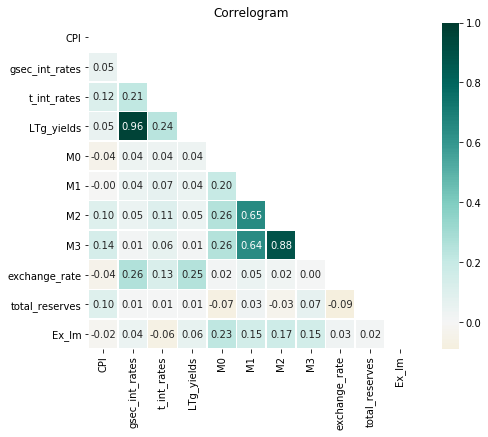

In [10]:
'''Visualizing the correlation matrix'''
correlogram = var_df.corr()
mask = np.zeros_like(a=correlogram, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.rcParams['figure.figsize'] = [10,6]
sns.heatmap(data=correlogram, annot=True, center=0, square=True, linewidths=0.5, cmap='BrBG', mask=mask, fmt='.2f')
plt.title('Correlogram')
plt.show()

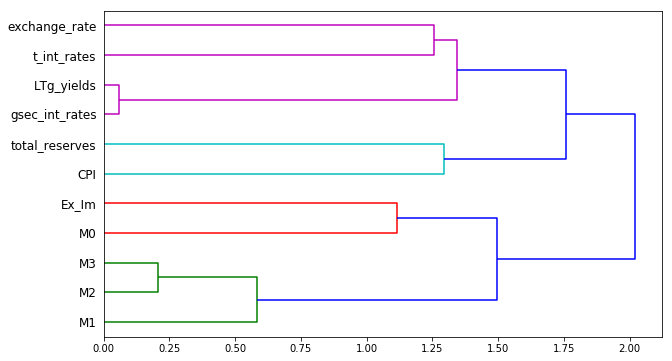

In [11]:
# final dendrogram
Z = hierarchy.linkage(correlogram, method='complete')
dendro = hierarchy.dendrogram(Z, labels=correlogram.columns.tolist(), orientation='right')

<p style='text-align:justify;'>From the above heatmap of correlogram, we can see high level of correlation present amongst the variables. The result of any model fitted on a such highly correlated data will be biased.
We therefore need to filter out redundant variables.
By heuristic approach, i.e., close observation of the above graph, one could safely conclude the variable of choice must be one from each category, *viz*., one of the interest rates, one of the money supply, exchange rate, inflation rate and trade balance.
The set of variables, with least overall correlation, to be used are:</p>

00. LT govt. yields.
01. M2 money supply.
02. CPI
03. Export-to-Import ratio.

In [12]:
factors = variables_norm[['LTg_yields', 'CPI', 'M2', 'Ex_Im']]

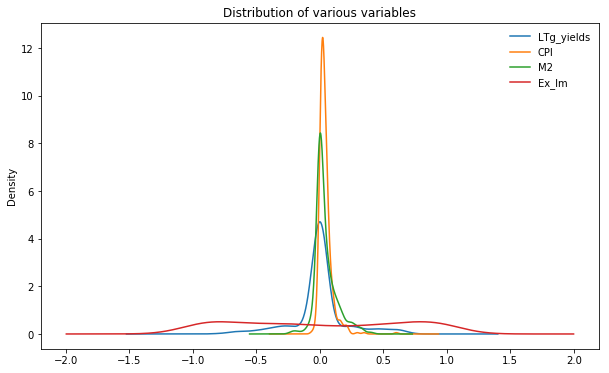

In [13]:
for i in factors.columns:
    factors[i].plot.kde(alpha=1);
plt.legend(labels=factors.columns, frameon=False, loc='best')
plt.title('Distribution of various variables')
plt.show()

#### Dimensionality reduction through PCA

In [14]:
'''Performing PCA on standardized data'''
from sklearn.decomposition import PCA
components = PCA()
scaled_variables = components.fit_transform(factors)

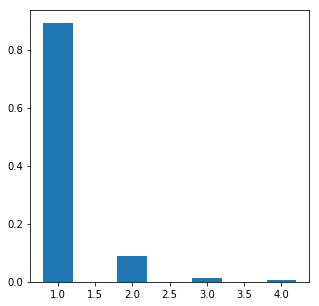

In [15]:
plt.figure(figsize=(5,5))
plt.bar(x=[1,2,3,4], height=components.explained_variance_ratio_, width=0.4);

In [16]:
'''Performing PCA on standardized data to come up with two components'''
components_2 = PCA(n_components=2)
scaled_variables_2 = components_2.fit_transform(factors.T)
p_components = pd.DataFrame(data=scaled_variables_2, columns=['comp_1', 'comp_2'], index=factors.columns.tolist())

print(f"{components_2.explained_variance_ratio_}")
print('='*80)
p_components.head()

[0.90256 0.08425]


,comp_1,comp_2
LTg_yields,-3.83641,3.10629
CPI,-3.58423,-1.47481
M2,-3.45279,-1.70113
Ex_Im,10.87343,0.06965


No handles with labels found to put in legend.


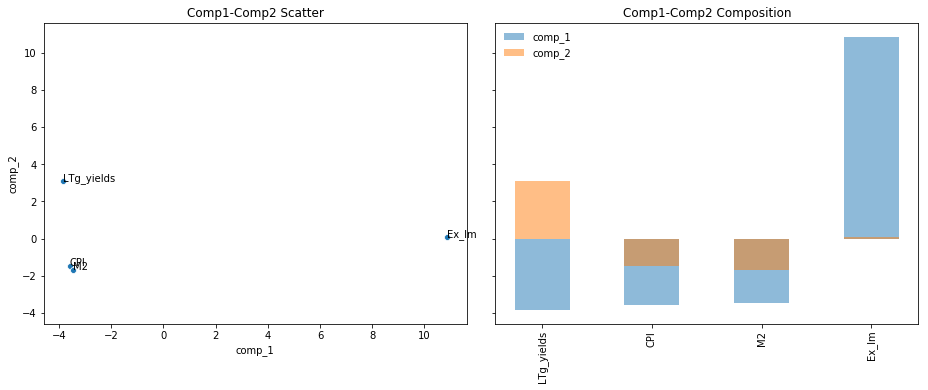

In [17]:
plt.rcParams['figure.figsize'] = (13,6)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True);
sns.scatterplot(x=p_components.comp_1, y=p_components.comp_2, ax=ax1);
ax1.set_title('Comp1-Comp2 Scatter')
ax1.legend(title=None, frameon=False, loc='best')
for sample in p_components.index:
    ax1.annotate(sample, (p_components.comp_1.loc[sample], p_components.comp_2.loc[sample]))
ax2.bar(x=p_components.index, height=p_components.comp_1, width=0.5, alpha=0.5);
ax2.bar(x=p_components.index, height=p_components.comp_2, width=0.5, alpha=0.5);
ax2.legend(labels=p_components.columns, loc='best', frameon=False, title=None)
ax2.set_title('Comp1-Comp2 Composition')
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Model fitting 

In [33]:
# CPI = pd.Series(data=variables['CPI'].diff(1)[1:], name='CPI')
# LTY = pd.Series(data=variables['LTg_yields'].diff(1)[1:], name='LTY')
# FX  = pd.Series(np.log(var_df['exchange_rate']+1).diff(1)[1:], name='FX')

CPI = pd.Series(data=variables['CPI'], name='CPI')
# LTY = pd.Series(data=variables['LTg_yields'], name='LTY')
# FX  = pd.Series(data=variables['exchange_rate'], name='FX')

In [19]:
CPI_tr = pd.Series(data=CPI[:np.floor(len(CPI.index)* 0.9).astype(np.int)], name='CPI_train')
# FX__tr = pd.Series(data=FX[:np.floor(len(CPI.index)* 0.9).astype(np.int)], name='FX_train')
# LTY_tr = pd.Series(data=LTY[:np.floor(len(CPI.index)* 0.9).astype(np.int)], name='LTY_train')

In [20]:
CPI_te = pd.Series(data=CPI[np.floor(len(CPI.index) * 0.9).astype(np.int):], name='CPI_test')
# FX__te = pd.Series(data=FX[np.floor(len(CPI.index) * 0.9).astype(np.int):], name='FX__test')
# LTY_te = pd.Series(data=LTY[np.floor(len(CPI.index) * 0.9).astype(np.int):], name='LTY_test')

In [21]:
def tsaplot(y, title, lags=None, figsize=(12,8)):
    '''
    Examine he patterns of ACF and PACF along with the time series plot and histogram
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(shape=layout, loc=(0,0))
    kde_ax = plt.subplot2grid(shape=layout, loc=(0,1))
    acf_ax = plt.subplot2grid(shape=layout, loc=(1,0))
    pacf_ax = plt.subplot2grid(shape=layout, loc=(1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot.kde(ax=kde_ax)
    kde_ax.set_title('Distribution')
    sm.graphics.tsa.plot_acf(x=y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(x=y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

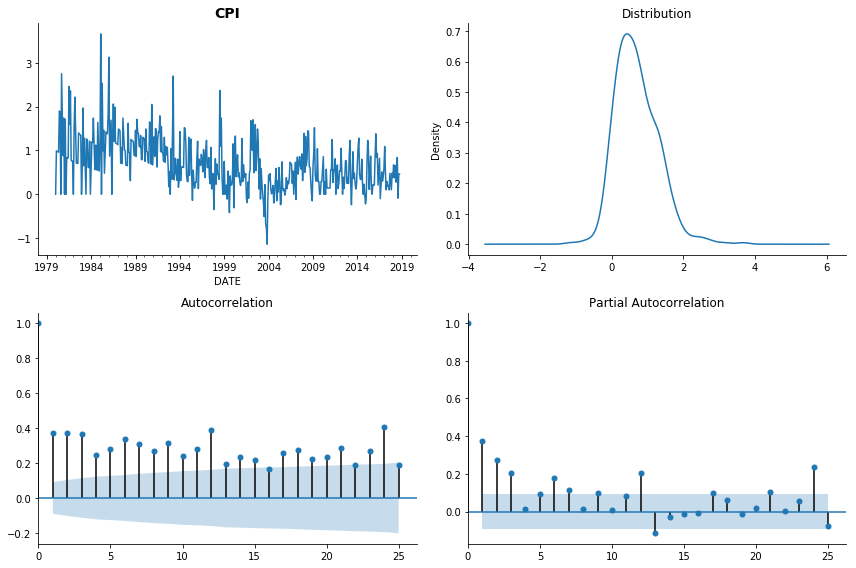

In [22]:
tsaplot(y=CPI, title='CPI', lags=25);

C:\Users\neelkanth mehta\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              CPI_train   No. Observations:                  419
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -352.202
Date:                Mon, 04 Feb 2019   AIC                            710.403
Time:                        09:59:35   BIC                            722.510
Sample:                    01-01-1980   HQIC                           715.189
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6767      0.035    -19.071      0.000      -0.746      -0.607
ar.L2         -0.3279      0.042     -7.892      0.000      -0.409      -0.246
sigma2         0.3154      0.016     19.539      0.000       0.284       0.347
===================================================================================
Ljung-Box (Q):                      135.53   Jarque-Bera (JB):                67.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

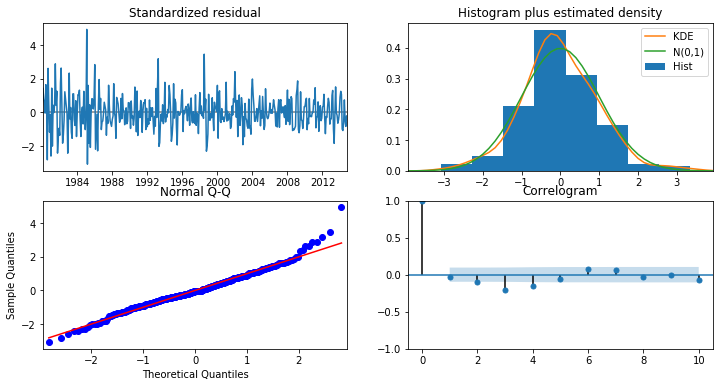

In [23]:
CPI_ar2 = sm.tsa.SARIMAX(endog=CPI_tr, order=(2,1,0))
CPI_model = CPI_ar2.fit()
CPI_model.plot_diagnostics(figsize=(12,6))
CPI_model.summary()

In [24]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = CPI_model.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = CPI_model.test_normality(norm_method)[0]
sercor_stat, sercor_p = CPI_model.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(CPI_model.filter_results.standardized_forecasts_error[0, CPI_model.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(CPI_model.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(CPI_model.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

Test heteroskedasticity of residuals (breakvar): stat=0.386, p=0.000

Test normality of residuals (jarquebera): stat=67.812, p=0.000

Test serial correlation of residuals (ljungbox): stat=135.529, p=0.000

Durbin-Watson test on residuals: d=2.06
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


Text(0.5, 1.0, 'CPI')

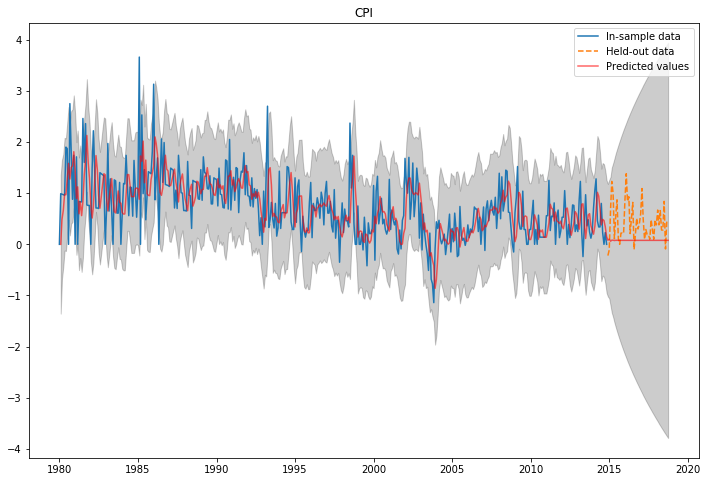

In [25]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(CPI_tr, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(CPI_te, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = CPI_tr.index[CPI_model.loglikelihood_burn]
pred_end = CPI_te.index[-1]
pred = CPI_model.get_prediction(start=pred_begin.strftime('%Y-%m-%d'), end=pred_end.strftime('%Y-%m-%d'), dynamic=False)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');
ax1.set_title('CPI')

In [87]:
# tsaplot(y=FX, title='FX', lags=25);

In [79]:
# FX_ar1 = sm.tsa.SARIMAX(endog=FX__tr, order=(1,2,0))
# FX_model = FX_ar1.fit()
# FX_model.plot_diagnostics(figsize=(12,6))
# FX_model.summary()

In [80]:
# het_method='breakvar'
# norm_method='jarquebera'
# sercor_method='ljungbox'

# (het_stat, het_p) = FX_model.test_heteroskedasticity(het_method)[0]
# norm_stat, norm_p, skew, kurtosis = FX_model.test_normality(norm_method)[0]
# sercor_stat, sercor_p = FX_model.test_serial_correlation(method=sercor_method)[0]
# sercor_stat = sercor_stat[-1] # last number for the largest lag
# sercor_p = sercor_p[-1] # last number for the largest lag

# dw = sm.stats.stattools.durbin_watson(FX_model.filter_results.standardized_forecasts_error[0, FX_model.loglikelihood_burn:])

# arroots_outside_unit_circle = np.all(np.abs(FX_model.arroots) > 1)

# maroots_outside_unit_circle = np.all(np.abs(FX_model.maroots) > 1)

# print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
# print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
# print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
# print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
# print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
# print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

In [81]:
# (variables.loc['1980-02':,'exchange_rate']*(pred_mean[1:] + pred_ci.iloc[1:,0]).add(1)).plot();
# (variables.loc['1980-02':,'exchange_rate']*(FX_model.get_prediction(start=FX.index[0], end=FX.index[-1]).predicted_mean).add(1)).plot();
# (variables.loc['1980-02':,'exchange_rate']*(pred_mean[1:] + pred_ci.iloc[1:,1]).add(1)).plot();

In [82]:
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
# ax1.plot(FX__tr, label='In-sample data', linestyle='-')
# # subtract 1 only to connect it to previous point in the graph
# ax1.plot(FX__te, label='Held-out data', linestyle='--')

# # yes DatetimeIndex
# pred_begin = FX__tr.index[CPI_model.loglikelihood_burn]
# pred_end = FX__te.index[-1]
# pred = FX_model.get_prediction(start=pred_begin.strftime('%Y-%m-%d'), end=pred_end.strftime('%Y-%m-%d'), dynamic=False)
# pred_mean = pred.predicted_mean
# pred_ci = pred.conf_int(alpha=0.05)

# ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
# ax1.fill_between(pred_ci.index,
#                  pred_ci.iloc[:, 0],
#                  pred_ci.iloc[:, 1], color='k', alpha=.2)

# ax1.legend(loc='best');
# ax1.set_title('FX')

In [83]:
# tsaplot(y=LTY, title='LTY', lags=25);

In [84]:
# LTY_ar1 = sm.tsa.SARIMAX(endog=LTY_tr, order=(1,2,0))
# LTY_model = LTY_ar1.fit()
# LTY_model.plot_diagnostics(figsize=(12,6))
# LTY_model.summary()

In [85]:
# het_method='breakvar'
# norm_method='jarquebera'
# sercor_method='ljungbox'

# (het_stat, het_p) = LTY_model.test_heteroskedasticity(het_method)[0]
# norm_stat, norm_p, skew, kurtosis = LTY_model.test_normality(norm_method)[0]
# sercor_stat, sercor_p = LTY_model.test_serial_correlation(method=sercor_method)[0]
# sercor_stat = sercor_stat[-1] # last number for the largest lag
# sercor_p = sercor_p[-1] # last number for the largest lag

# dw = sm.stats.stattools.durbin_watson(LTY_model.filter_results.standardized_forecasts_error[0, LTY_model.loglikelihood_burn:])

# arroots_outside_unit_circle = np.all(np.abs(LTY_model.arroots) > 1)

# maroots_outside_unit_circle = np.all(np.abs(LTY_model.maroots) > 1)

# print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
# print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
# print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
# print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
# print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
# print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

In [86]:
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
# ax1.plot(LTY_tr, label='In-sample data', linestyle='-')
# # subtract 1 only to connect it to previous point in the graph
# ax1.plot(LTY_te, label='Held-out data', linestyle='--')

# # yes DatetimeIndex
# pred_begin = LTY_tr.index[CPI_model.loglikelihood_burn]
# pred_end = LTY_te.index[-1]
# pred = LTY_model.get_prediction(start=pred_begin.strftime('%Y-%m-%d'), end=pred_end.strftime('%Y-%m-%d'), dynamic=False)
# pred_mean = pred.predicted_mean
# pred_ci = pred.conf_int(alpha=0.05)

# ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
# ax1.fill_between(pred_ci.index[1:],
#                  pred_ci.iloc[1:, 0],
#                  pred_ci.iloc[1:, 1], color='k', alpha=.2)

# ax1.legend(loc='best');
# ax1.set_title('LTY')